In [1]:
%reload_ext autoreload
%autoreload 2
'''
if autoreload does not work, try import the python file as a module and then reload the file and the module
import plotting_follow_analysis
import importlib
importlib.reload(plotting_follow_analysis)
from plotting_follow_analysis import plot_follow_response_distribution'''

'\nif autoreload does not work, try import the python file as a module and then reload the file and the module\nimport plotting_follow_analysis\nimport importlib\nimportlib.reload(plotting_follow_analysis)\nfrom plotting_follow_analysis import plot_follow_response_distribution'

In [2]:
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from quantify_color_spectrum import load_color_spectrum

In [212]:
##introduce some helper class to define colour gradient
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
#colormap_name = "viridis"
colormap_name = "hsv"
#colormap_name="Set1"

In [ ]:
def list_up_files(thisDataset,file_type=".txt"):
    dir_list=[]
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            for name in os.listdir(folder_path):
                if name.endswith(file_type):
                    this_file_dir=os.path.join(folder_path.replace("\\", "/"),name)
                    dir_list.append(this_file_dir.replace("\\", "/"))
    return dir_list

In [439]:
dir_list=list_up_files(r"Z:\Users\chiyu\ILT2500\Z745_VG279QM",".csv")

In [420]:
dir_list1=dir_list[107:124]

In [426]:
dir_list2=dir_list[124:141]

In [434]:
dir_list3=dir_list[141:158]

In [355]:
dir_list=dir_list[166:184]

In [362]:
dir_list=dir_list[184:]

In [440]:
dir_list[-1:]

['Z:/Users/chiyu/ILT2500/Z745_VG279QM/session17/single_sample_file.csv']

In [441]:
array_list=[]
for this_file in dir_list[-1:]:
    pd0=pd.read_csv(this_file,delimiter=",",skiprows=0)
    array_list.append(pd0['W/cm2'].values)

In [ ]:
###calculate contrast of foreground background combination in session 16
tmp=pd0['W/cm2'].values
lux_array=np.reshape(tmp,(7,22))
background_foreground_contrast_array=np.zeros((11,7))
for j in range(lux_array.shape[0]):
    background=lux_array[j,::2]
    foreground=lux_array[j,1::2]
    background_foreground_contrast_array[:,j]=np.transpose((foreground-background)/background)

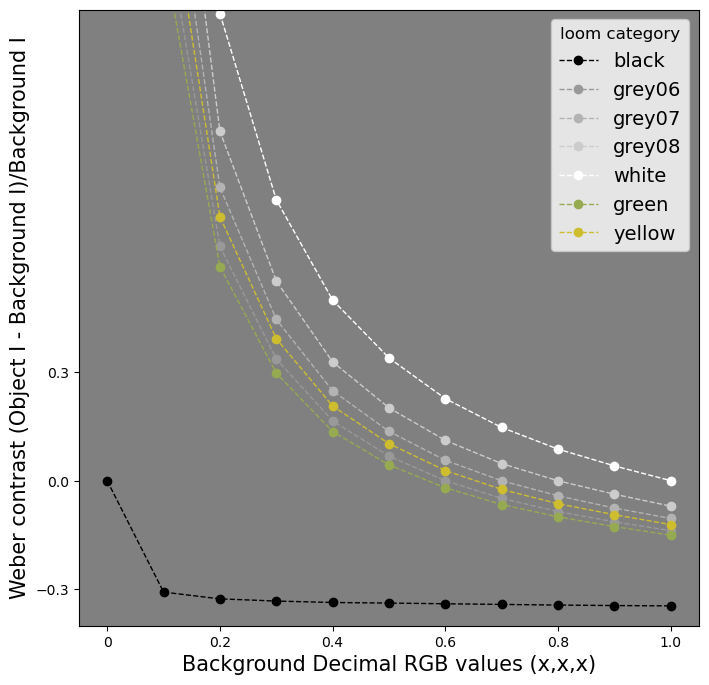

In [ ]:
###plotting contrast of foreground background combination in session 16
color_list=[(0, 0, 0),(0.6, 0.6, 0.6),(0.7, 0.7, 0.7),(0.8, 0.8, 0.8),(1.0,1.0,1.0),(0.5882,0.6705,0.3176),(0.8117,0.7411,0.1882)]
category_list=['black','grey06','grey07','grey08','white','green','yellow']
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(8,8))
for i in range(background_foreground_contrast_array.shape[1]):
    ax1.plot(background_foreground_contrast_array[:,i],linestyle='--', marker='o',linewidth=1,color=color_list[i],label=category_list[i])
#ax1.plot(background_foreground_contrast_array[:,7:11],linestyle='--', marker='o',linewidth=1)
ax1.set_facecolor("grey")
ax1.legend(title='loom category',prop={'size': 14},title_fontsize=12,loc='upper right')
ax1.set(
    xticks=[0,2,4,6,8,10],
    xticklabels=(['0','0.2','0.4','0.6','0.8','1.0']),
    xlabel=('Background Decimal RGB values (x,x,x)'),
    ylabel= ('Weber contrast (Object I - Background I)/Background I'),
    yticks=[-0.3,0.0,0.3],
    ylim=[-0.4,1.3]
    )
ax1.xaxis.label.set(fontsize=15)
ax1.yaxis.label.set(fontsize=15)

In [445]:
###calculate contrast of locust background combination in session 17
tmp=pd0['W/cm2'].values
lux_array=np.reshape(tmp,(4,18))
locust_background_contrast_array=np.zeros((9,4))
for j in range(lux_array.shape[0]):
    background=lux_array[j,::2]
    foreground=lux_array[j,1::2]
    locust_background_contrast_array[:,j]=np.transpose((foreground-background)/background)

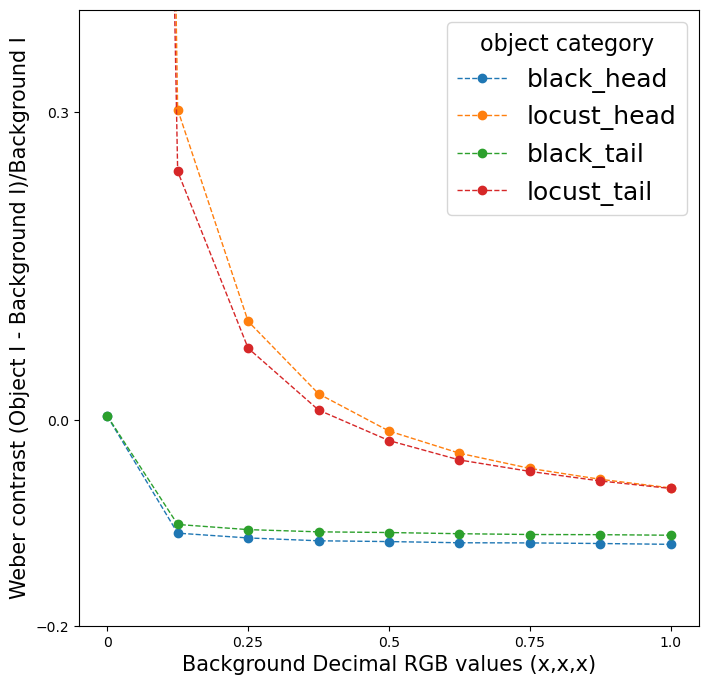

In [451]:
locust_list=['black_head','locust_head','black_tail','locust_tail']
#locust_list=['black_tail','locust_tail']
#locust_list=['black_head','locust_head']
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(8,8))
for i in range(locust_background_contrast_array.shape[1]):
    ax1.plot(locust_background_contrast_array[:,i],linestyle='--', marker='o',linewidth=1,label=locust_list[i])
ax1.legend(title='object category',prop={'size': 18},title_fontsize=16)
ax1.set(
    xticks=[0,2,4,6,8],
    xticklabels=(['0','0.25','0.5','0.75','1.0']),
    xlabel=('Background Decimal RGB values (x,x,x)'),
    ylabel= ('Weber contrast (Object I - Background I)/Background I'),
    yticks=[-0.2,0.0,0.3],
    ylim=[-0.2,0.4]
    )
ax1.xaxis.label.set(fontsize=15)
ax1.yaxis.label.set(fontsize=15)

In [280]:
print(dir_list)
gray_array=array_list[2][:11]
r_array=array_list[3][:11]
g_array=array_list[1][:11]
b_array=array_list[0][:11]

['Z:/Users/chiyu/ILT2500/Z745_VG279QM/session13/ILTB21-Sep-2025 111822.csv', 'Z:/Users/chiyu/ILT2500/Z745_VG279QM/session13/ILTG21-Sep-2025 112058.csv', 'Z:/Users/chiyu/ILT2500/Z745_VG279QM/session13/ILTK21-Sep-2025 111552.csv', 'Z:/Users/chiyu/ILT2500/Z745_VG279QM/session13/ILTR21-Sep-2025 112334.csv']


In [91]:
gray_array=(array_list[4]+np.flip(array_list[5]))/2
r_array=(array_list[6]+np.flip(array_list[7]))/2
g_array=(array_list[2]+np.flip(array_list[3]))/2
b_array=(array_list[0]+np.flip(array_list[1]))/2

In [281]:
np.savetxt('rgb_scale_4_gamma_calibration_ITL2500_20250919_calibrated_color_app_session13.csv', np.vstack((r_array,g_array,b_array,gray_array)), delimiter=',')

In [ ]:
auc_list=[]
wavelength_list=[]
#sort list according to their time
directory = r"C:\Users\neuroPC\Documents\color_spetrum\Z745_VG279QM"
file_list=os.listdir(directory)
def last_nchars(x):
    return(x[-7:])
sorted_file_list=sorted(file_list, key = last_nchars)
for this_file in sorted_file_list[:-2]: # used for data from 20250805
#for this_file in sorted_file_list:# used for data from 20250806
    print(this_file)
    auc, wavelength=load_color_spectrum(os.path.join(directory, this_file),remove_uv_spectrum=True,add_opsin_sensitivity_weight=True,convert_irradiance_to_photon_energy=True,varying_integration_time=True)
    auc_list.append(auc)
    wavelength_list.append(wavelength)

In [ ]:
# used for data from 20250806
gray_scale=auc_list[44:55]
r_scale=auc_list[55:66]
g_scale=auc_list[66:77]
b_scale=auc_list[77:88]
gray_array=(np.array(auc_list[:11])+np.flip(np.array(gray_scale)))/2
r_array=(np.array(auc_list[11:22])+np.flip(np.array(r_scale)))/2
g_array=(np.array(auc_list[22:33])+np.flip(np.array(g_scale)))/2
b_array=(np.array(auc_list[33:44])+np.flip(np.array(b_scale)))/2

In [ ]:
# used for data from 20250805
rgb000=auc_list[1:11]
#mean_rbg000=np.mean(rgb000)
mean_rbg000=rgb000[0]
gray_scale=auc_list[11:-30]
gray_array=np.mean(np.array(gray_scale).reshape((10, -1)),axis=1)
r_scale=auc_list[61:71]
g_scale=auc_list[71:81]
b_scale=auc_list[81:]
r_array=np.array(r_scale)
g_array=np.array(g_scale)
b_array=np.array(b_scale)

In [ ]:
# used for data from 20250805 use the minimum value of those arrays as the RGB000
gray_array = np.insert(gray_array, 0, min(gray_scale))
r_array = np.insert(r_array, 0, min(r_array))
g_array = np.insert(g_array, 0, min(g_array))
b_array = np.insert(b_array, 0, min(b_array))

In [ ]:
# used for data from 20250805 use the mean RGB000
gray_array = np.insert(gray_array, 0, mean_rbg000)
r_array = np.insert(r_array, 0, mean_rbg000)
g_array = np.insert(g_array, 0, mean_rbg000)
b_array = np.insert(b_array, 0, mean_rbg000)

In [ ]:
np.savetxt('rgb_scale_4_gamma_calibration_opsin_photons_20250805.csv', np.vstack((gray_array,r_array,g_array,b_array)), delimiter=',')

In [ ]:
#sort list according to their time
def last_nchars(x):
    return(x[-16:])

In [ ]:
## data for gamma correction
multiple_trials=False
if multiple_trials:
    folders=["gray_scale","red_scale","green_scale","blue_scale"]
    Dataset_dir =Path("C:/Users/neuroPC/Documents/color_spetrum/matrexVR_20241104")
else:
    folders=["gray","red","green","blue"]
    Dataset_dir =Path("C:/Users/neuroPC/Documents/color_spetrum/matrexVR_20241127")
mean_auc_list=[]
for this_folder in folders:
    thisDataset=Dataset_dir / f"{this_folder}"
    if multiple_trials:
        dir_list=list_up_files(thisDataset)
    else:
        dir_list=[os.path.join(str(thisDataset),s) for s in os.listdir(str(thisDataset))]
    sorted_data_list=sorted(dir_list, key = last_nchars)
    auc_list=[]
    wavelength_list=[]
    for this_file_path in sorted_data_list:
        print(f"processing {this_file_path}")
        if "archive" in this_file_path:
            continue
        else:
            auc, wavelength=load_color_spectrum(this_file_path,remove_uv_spectrum=False,add_opsin_sensitivity_weight=False,convert_irradiance_to_photon_energy=False)
            auc_list.append(auc)
            wavelength_list.append(wavelength)
    if multiple_trials:
        auc_array=np.reshape(np.array(auc_list),(2,-1))
        mean_auc_list.append(np.mean(auc_array,axis=0))
    else:
        mean_auc_list.append(np.array(auc_list))

In [ ]:
np.savetxt('rgb_scale_4_gamma_calibration.csv', np.vstack(mean_auc_list), delimiter=',')

# Z745 measurement 17 levels of gray (from 0 to 1 with 0.0625 increment)
# (5 + 1) foreground * 17 background = 102 combination
# (1) 102 combination with 3 repeats at 5 different distance = 1530 measurement
# Each measurement takes 5 seconds means the whole experiment takes 127.5 mins (7650 seconds)
# (2) 102 combination with 3 repeats at 3 different distance = 918 measurement
# Each measurement takes 5 seconds means the whole experiment takes 76.5 mins (4590 seconds)

## in Computation of Object Approach by a Wide-Field, Motion-Sensitive Neuron 
# The luminance of the screen was calibrated linearly between 0 cd/m2 and a maximal luminance Imax of 95 cd/m2, as measured at a distance of 46 cm from the center of the screen with a photometer (PR-504 and PR-502; Photometer Research, Chatsworth, CA). 



In [ ]:
#folders=["gregarious","yellow1","yellow2","green","white","black","3Dwhite","3Dblack"]
folders=["gregarious","yellow1","yellow2","green","white","black"]
exp="choice"
Dataset_dir =Path("C:/Users/neuroPC/Documents/color_spetrum/matrexVR_20241127")
mean_auc_list=[]
for this_folder in folders:
    thisDataset=Dataset_dir / f"{exp}_{this_folder}"
    dir_list=[os.path.join(str(thisDataset),s) for s in os.listdir(str(thisDataset))]
    sorted_data_list=sorted(dir_list, key = last_nchars)
    auc_list=[]
    wavelength_list=[]
    for this_file_path in sorted_data_list:
        if "archive" in this_file_path:
            print(f"skip archive folder for {this_file_path}")
            continue
        else:
            print(f"no curated matrexvr h5 database in {this_file_path}. Create curated file")
            auc, wavelength=load_color_spectrum(this_file_path)
            auc_list.append(auc)
            wavelength_list.append(wavelength)
    #auc_array=np.reshape(np.array(auc_list),(2,-1))
    #mean_auc_list.append(auc_array[1,:])
    mean_auc_list.append(np.array(auc_list))

In [ ]:
#thisDataset=Path("C:/Users/neuroPC/Documents/color_spetrum/matrexVR_20241127/background") background1 has problems during the acqusition
thisDataset=Path("C:/Users/neuroPC/Documents/color_spetrum/matrexVR_20241127/background2")
dir_list=[os.path.join(str(thisDataset),s) for s in os.listdir(str(thisDataset))]
sorted_data_list=sorted(dir_list, key = last_nchars)
auc_list=[]
wavelength_list=[]
for this_file_path in sorted_data_list:
    if "archive" in this_file_path:
        print(f"skip archive folder for {this_file_path}")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_file_path}. Create curated file")
        auc, wavelength=load_color_spectrum(this_file_path)
        auc_list.append(auc)
        wavelength_list.append(wavelength)

In [ ]:
if exp=="choice":
    choice_mean_auc_list=mean_auc_list
    auc_array_conditions=np.vstack(choice_mean_auc_list)
else:
    band_mean_auc_list=mean_auc_list
    auc_array_conditions=np.vstack(band_mean_auc_list)

In [ ]:
background=np.array(auc_list)
background=background[0:16]

In [ ]:
background2=np.array(auc_list)

In [ ]:
m_contrast=abs(auc_array_conditions-background2)/(auc_array_conditions+background2)
w_contrast=(auc_array_conditions-background2)/background2
w_contrast_abs=abs(auc_array_conditions-background2)/background2

In [ ]:
COL = MplColorHelper(colormap_name, 0, m_contrast.shape[0]-1)
sm = cm.ScalarMappable(cmap=colormap_name)
graph_colour_code=["r","m","y","g","c","k"]

In [ ]:
## the function to calculate that is incorrect does not support data 
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(8,8))
for i in range(w_contrast.shape[0]):
    if i==4:
        continue## skip white
    ax1.plot(w_contrast[i,:-1],color=graph_colour_code[i],label=folders[i], linestyle='--', marker='o',linewidth=1)
ax1.legend(title='object category',prop={'size': 18},title_fontsize=16)
ax1.set(
    xticks=[0,3,6,9,12,15],
    xticklabels=(['0','0.2','0.4','0.6','0.8','1.0']),
    xlabel=('Background Decimal RGB values (x,x,x)'),
    ylabel= ('Weber contrast (Object I - Background I)/Background I'),
    yticks=[-0.2,0.0,0.2,0.4],
    ylim=[-0.2,0.4])
ax1.xaxis.label.set(fontsize=15)
ax1.yaxis.label.set(fontsize=15)
#ax1.yaxis.label.set(fontsize=20)
#background1 suggest the 7th has closest contrast between black and gregarious

In [ ]:
## the function to calculate that is incorrect does not support data 
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(8,8))
for i in range(w_contrast_abs.shape[0]):
    if i==4:
        continue## skip white
    ax1.plot(w_contrast_abs[i,:-1],color=graph_colour_code[i],label=folders[i], linestyle='--', marker='o',linewidth=1)
ax1.legend(title='object category',prop={'size': 18},title_fontsize=16)
ax1.set(
    xticks=[0,3,6,9,12,15],
    xticklabels=(['0','0.2','0.4','0.6','0.8','1.0']),
    xlabel=('Background Decimal RGB values (x,x,x)'),
    ylabel= ('Weber contrast (Object I - Background I)/Background I'),
    yticks=[0.0,0.2,0.4],
    ylim=[-0.05,0.4])
ax1.xaxis.label.set(fontsize=15)
ax1.yaxis.label.set(fontsize=15)
#ax1.yaxis.label.set(fontsize=20)
#background1 suggest the 7th has closest contrast between black and gregarious

In [ ]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(8,8))
for i in range(m_contrast.shape[0]):
    ax1.plot(m_contrast[i,:-1],color=graph_colour_code[i],label=folders[i], linestyle='--', marker='o',linewidth=1)
ax1.legend(title='object category',prop={'size': 18},title_fontsize=16)
ax1.set(
    xticks=[0,3,6,9,12,15],
    xticklabels=(['0','0.2','0.4','0.6','0.8','1.0']),
    xlabel=('Background Decimal RGB values (x,x,x)'),
    ylabel= ('Michelson contrast (Max I - Min I)/(Max I + Min I)'),
    yticks=[0.0,0.4,0.8],
    ylim=[-0.05,0.8])
ax1.xaxis.label.set(fontsize=15)
ax1.yaxis.label.set(fontsize=15)
#ax1.yaxis.label.set(fontsize=20)
#background1 suggest the 7th has closest contrast between black and gregarious

In [ ]:
#background  measurement
plt.plot(np.arange(background.shape[0]),background)